## Machine Learning to Predict Rank within Starcraft Dataset 
### By: Summer Long

#### Importing dataset

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [111]:
## apply same transformations deemed necessary from EDA

sc = pd.read_csv('data/starcraft_player_data.csv')
sc.replace('?', np.nan, inplace=True)
sc.loc[:, sc.columns[2:5]] = sc.loc[:, sc.columns[2:5]].astype('float64')

/var/folders/jk/qsm240p56v71nzsk7_mwm5bh0000gn/T/ipykernel_58178/858709906.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sc.loc[:, sc.columns[2:5]] = sc.loc[:, sc.columns[2:5]].astype('float64')


In [112]:
## dictionary to map string representation to LeagueIndex

rank_dict = {1: 'Bronze', 
             2: 'Silver', 
             3: 'Gold', 
             4: 'Platinum', 
             5: 'Diamond', 
             6: 'Master',
             7: 'GrandMaster',
             8: 'Professional leagues'}

sc.loc[:, 'Rank'] = sc.loc[:, 'LeagueIndex'].apply(lambda x: rank_dict.get(x))

sc.loc[:, 'LeagueIndex_ML'] = sc.loc[:, 'LeagueIndex'] - 1 



In [113]:
from sklearn.model_selection import train_test_split
X = sc.drop(['LeagueIndex', 'GameID', 'LeagueIndex_ML', 'Rank', 'Age', 'HoursPerWeek', 'TotalHours', 'UniqueUnitsMade', 'ActionsInPAC'], axis=1)
y = sc.loc[:, 'LeagueIndex_ML']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [114]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, roc_auc_score


In [115]:
scoring = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

In [116]:
def confusion_matrix_plot(y_test, y_pred):
    confusion_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


### Model number 1: XGBoost

In [117]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

In [118]:
params = {
    'learning_rate': np.arange(0.05, 0.5, 0.05),
    'max_depth': np.arange(3, 10),
    'n_estimators': np.arange(50, 500, 50),
    'min_child_weight': np.arange(1, 10),
    'gamma': np.arange(0, 0.5, 0.1),
    'colsample_bytree': np.arange(0.3, 1.0, 0.1)
}

xgb_clf = xgb.XGBClassifier(objective='multi:softmax')
rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, cv=5, scoring=scoring)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'colsample_bytree': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4]),
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [119]:
best_params = rs.best_params_
best_estimator = rs.best_estimator_
y_pred_prob = best_estimator.predict_proba(X_test)


In [120]:
y_pred = best_estimator.predict(X_test)
auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print("AUC-ROC score:", auc_roc)


AUC-ROC score: 0.8072413065457382


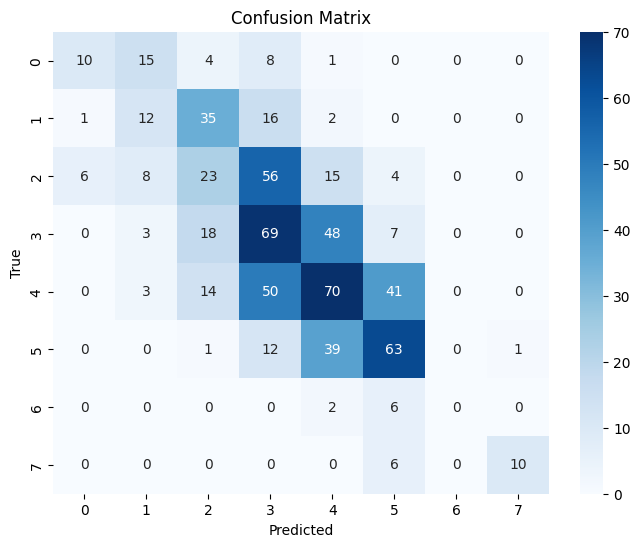

In [121]:
confusion_matrix_plot(y_test, y_pred)

In [122]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3784977908689249


### Model number 2: Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
paramsv2 = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 10),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 6),
    'max_features': ['sqrt', 'log2']
}


rf_clf = RandomForestClassifier()
rsv2 = RandomizedSearchCV(estimator=rf_clf, param_distributions=paramsv2, cv=5, scoring=scoring)
rsv2.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [125]:
best_estimatorv2 = rsv2.best_estimator_
y_pred_probv2 = best_estimatorv2.predict_proba(X_test)
y_predv2 = best_estimatorv2.predict(X_test)

auc_rocv2 = roc_auc_score(y_test, y_pred_probv2, multi_class='ovr')
print("AUC-ROC score:", auc_rocv2)

AUC-ROC score: 0.8259096128730647


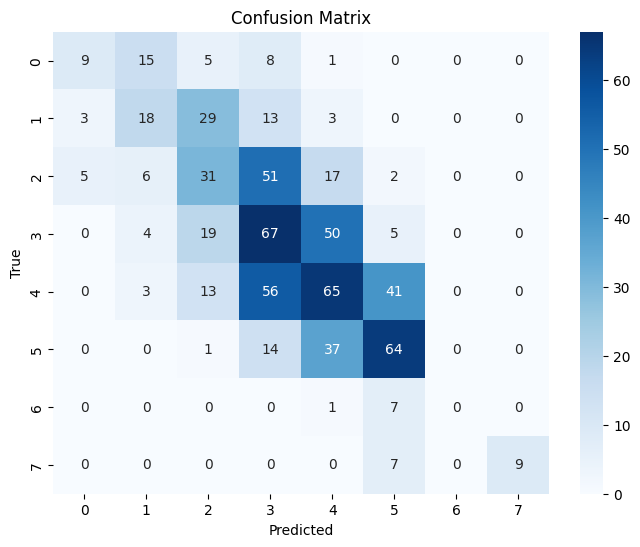

In [126]:
confusion_matrix_plot(y_test, y_predv2)


In [127]:
accuracyv2 = accuracy_score(y_test, y_predv2)
print("Accuracy:", accuracyv2)

Accuracy: 0.3873343151693667


### Model Number 3: Logistic Regression

In [128]:
from sklearn.linear_model import LogisticRegression

In [130]:
paramsv3 = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['liblinear', 'saga'],
    'max_iter': [5000]
}

logreg_clf = LogisticRegression(multi_class='auto')
rsv3 = RandomizedSearchCV(estimator=logreg_clf, param_distributions=paramsv3, cv=5, scoring=scoring)
rsv3.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'max_iter': [5000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [131]:
best_estimatorv3 = rsv3.best_estimator_
y_pred_probv3 = best_estimatorv3.predict_proba(X_test)
y_predv3 = best_estimatorv3.predict(X_test)

auc_rocv3 = roc_auc_score(y_test, y_pred_probv3, multi_class='ovr')
print("AUC-ROC score:", auc_rocv3)

AUC-ROC score: 0.818329708965277


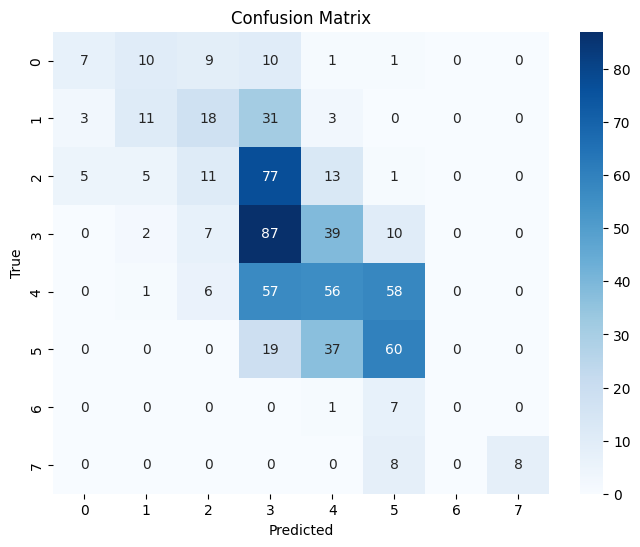

In [132]:
confusion_matrix_plot(y_test, y_predv3)

In [133]:
accuracyv3 = accuracy_score(y_test, y_predv3)
print("Accuracy:", accuracyv3)

Accuracy: 0.35346097201767307


From the confusion matrices above, it appears that the models are strong at observing within +/- 1 rank what the player is.

So, using the best performing model from AUC-ROC and raw accuracy (random forest), I will use an ensemble method to construct a model. 

It will first group the models into 3 categories: the first pass will do (Bronze, Silver, Gold), (Platinum, Diamond, Master), (GM, Professional League); the second pass will do (Bronze, Silver, Gold, Platinum), (Diamond, Master), (GM, Professional League).

Once it is classified into one of the three categories, a more specific model will classify within category.

#### Ensemble Approach

In [134]:
rank_category_train = np.where((y_train == 0) | (y_train == 1) | (y_train == 2), 1, np.where((y_train == 3) | (y_train == 4) | (y_train == 5), 2, 3))
rank_category_test = np.where((y_test == 0) | (y_test == 1) | (y_test == 2), 1, np.where((y_test == 3) | (y_test == 4) | (y_test == 5), 2, 3))

In [135]:
rf_clf_category = RandomForestClassifier()
rsv_category = RandomizedSearchCV(estimator=rf_clf_category, param_distributions=paramsv2, cv=5, scoring=scoring)
rsv_category.fit(X_train, rank_category_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [136]:
best_estimator_classifier = rsv_category.best_estimator_
y_pred_prob_classifier = best_estimator_classifier.predict_proba(X_test)
y_pred_classifier = best_estimator_classifier.predict(X_test)

auc_roc_classifier = roc_auc_score(rank_category_test, y_pred_prob_classifier, multi_class='ovr')
print("AUC-ROC score:", auc_roc_classifier)

AUC-ROC score: 0.8970789636729948


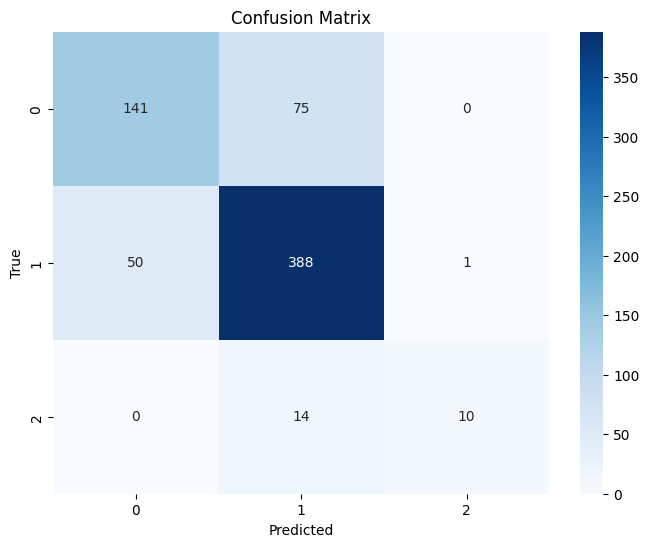

In [137]:
confusion_matrix_plot(rank_category_test, y_pred_classifier)

In [138]:
accuracy_classifier = accuracy_score(rank_category_test, y_pred_classifier)
print("Accuracy:", accuracy_classifier)

Accuracy: 0.7938144329896907


In [139]:
rank_category_trainv2 = np.where((y_train == 0) | (y_train == 1) | (y_train == 2) | (y_train == 3), 1, np.where((y_train == 4) | (y_train == 5), 2, 3))
rank_category_testv2 = np.where((y_test == 0) | (y_test == 1) | (y_test == 2) | (y_test == 3), 1, np.where((y_test == 4) | (y_test == 5), 2, 3))

In [140]:
rf_clf_categoryv2 = RandomForestClassifier()
rsv_categoryv2 = RandomizedSearchCV(estimator=rf_clf_categoryv2, param_distributions=paramsv2, cv=5, scoring=scoring)
rsv_categoryv2.fit(X_train, rank_category_trainv2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [141]:
best_estimator_classifierv2 = rsv_categoryv2.best_estimator_
y_pred_prob_classifierv2 = best_estimator_classifierv2.predict_proba(X_test)
y_pred_classifierv2 = best_estimator_classifierv2.predict(X_test)

auc_roc_classifierv2 = roc_auc_score(rank_category_testv2, y_pred_prob_classifierv2, multi_class='ovr')
print("AUC-ROC score:", auc_roc_classifierv2)

AUC-ROC score: 0.8874677266336396


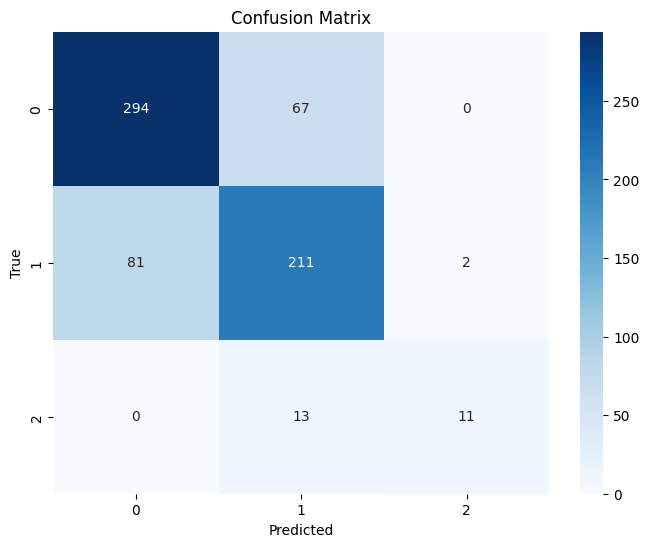

In [142]:
confusion_matrix_plot(rank_category_testv2, y_pred_classifierv2)

In [143]:
accuracy_classifierv2 = accuracy_score(rank_category_testv2, y_pred_classifierv2)
print("Accuracy:", accuracy_classifierv2)

Accuracy: 0.759941089837997


Proceeding with the first grouping, now attempting to classify within group

In [144]:
X_train_category1 = X_train[rank_category_train == 1]
X_train_category2 = X_train[rank_category_train == 2]
X_train_category3 = X_train[rank_category_train == 3]
y_train_cat1 = y_train[rank_category_train == 1]
y_train_cat2 = y_train[rank_category_train == 2]
y_train_cat3 = y_train[rank_category_train == 3]


In [145]:
rf_clf_category1 = RandomForestClassifier()
rsv_category1 = RandomizedSearchCV(estimator=rf_clf_category1, param_distributions=paramsv2, cv=5, scoring=scoring)
rsv_category1.fit(X_train_category1, y_train_cat1)
rf_clf_category2 = RandomForestClassifier()
rsv_category2 = RandomizedSearchCV(estimator=rf_clf_category2, param_distributions=paramsv2, cv=5, scoring=scoring)
rsv_category2.fit(X_train_category2, y_train_cat2)
rf_clf_category3 = RandomForestClassifier()
rsv_category3 = RandomizedSearchCV(estimator=rf_clf_category3, param_distributions=paramsv2, cv=5, scoring=scoring)
rsv_category3.fit(X_train_category3, y_train_cat3)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [146]:
X_test_cat1 = X_test[rank_category_test == 1]
X_test_cat2 = X_test[rank_category_test == 2]
X_test_cat3 = X_test[rank_category_test == 3]
y_test_cat1 = y_test[rank_category_test == 1]
y_test_cat2 = y_test[rank_category_test == 2]
y_test_cat3 = y_test[rank_category_test == 3]


In [147]:
## category 1 model
best_estimator_classifier1 = rsv_category1.best_estimator_
y_pred_prob_classifier1 = best_estimator_classifier1.predict_proba(X_test_cat1)
y_pred_classifier1 = best_estimator_classifier1.predict(X_test_cat1)

auc_roc_classifier1 = roc_auc_score(y_test_cat1, y_pred_prob_classifier1, multi_class='ovr')
print("AUC-ROC score:", auc_roc_classifier1)

AUC-ROC score: 0.7211700569728364


In [148]:
accuracy1 = accuracy_score(y_test_cat1, y_pred_classifier1)
print("Accuracy:", accuracy1)

Accuracy: 0.5787037037037037


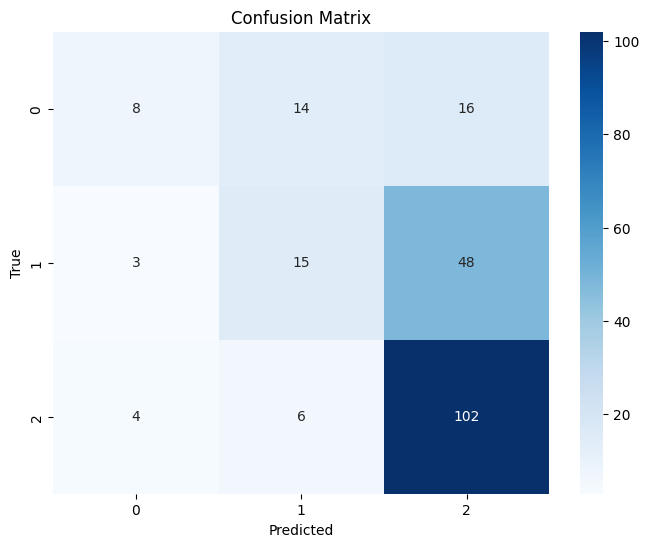

In [149]:
confusion_matrix_plot(y_test_cat1, y_pred_classifier1)

In [150]:
## category 2 model
best_estimator_classifier2 = rsv_category2.best_estimator_
y_pred_prob_classifier2 = best_estimator_classifier2.predict_proba(X_test_cat2)
y_pred_classifier2 = best_estimator_classifier2.predict(X_test_cat2)

auc_roc_classifier2 = roc_auc_score(y_test_cat2, y_pred_prob_classifier2, multi_class='ovr')
print("AUC-ROC score:", auc_roc_classifier2)

AUC-ROC score: 0.6904938539193713


In [151]:
accuracy2 = accuracy_score(y_test_cat2, y_pred_classifier2)
print("Accuracy:", accuracy2)

Accuracy: 0.5034168564920274


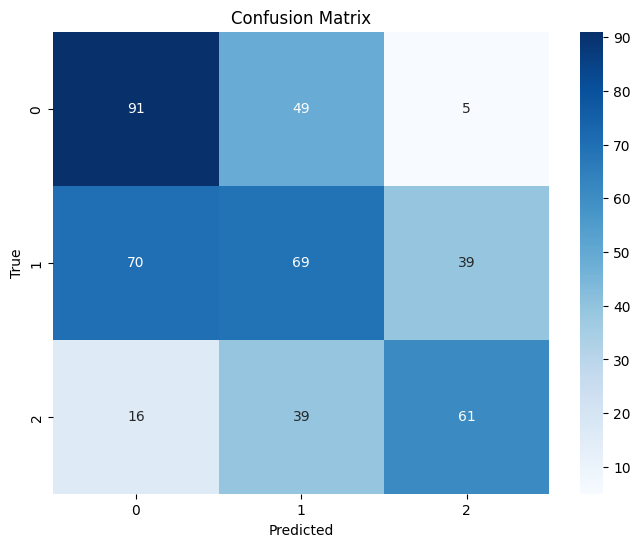

In [152]:
confusion_matrix_plot(y_test_cat2, y_pred_classifier2)

In [153]:
## category 3 model
best_estimator_classifier3 = rsv_category3.best_estimator_
y_pred_classifier3 = best_estimator_classifier3.predict(X_test_cat3)


In [154]:
accuracy3 = accuracy_score(y_test_cat3, y_pred_classifier3)
print("Accuracy:", accuracy3)

Accuracy: 0.6666666666666666


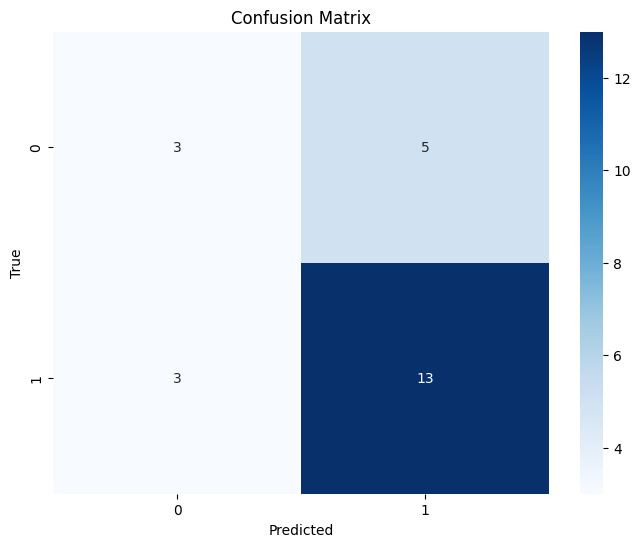

In [155]:
confusion_matrix_plot(y_test_cat3, y_pred_classifier3)

Overall, it seems the ensemble method is weaker than using one model to predict the rank of players. The AUC-ROC scores are signficantly lower for the individual models to select a rank within category. The AUC-ROC for putting players into one of three categories is strong (.9), suggesting that players within 1 rank of each other are quite similar.

The best model is the standalone Random Forest model.

#### Feature importances for Random Forest model

In [156]:
feature_importances = best_estimatorv2.feature_importances_
feature_names = X_train.columns

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]


In [167]:
sorted_feature_importances

array([0.18687882, 0.17347827, 0.11274038, 0.09959587, 0.09481017,
       0.07234919, 0.06255187, 0.05288161, 0.03910845, 0.03212672,
       0.0290639 , 0.02634459, 0.01807014])

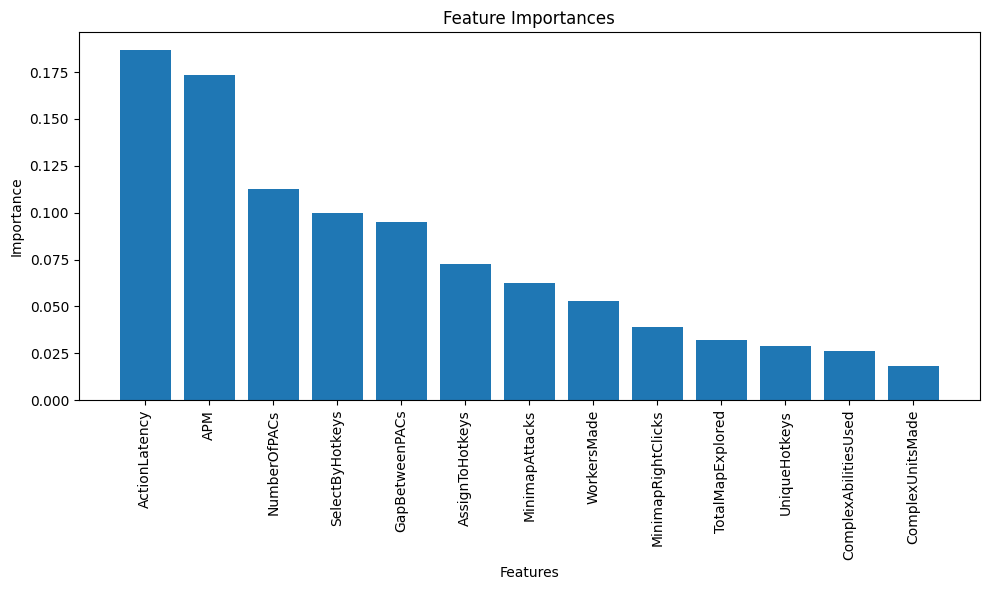

In [157]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


Since some features are lower in importance, one last model will be built excluding these importances below < .30. If this model performs better, it will be settled on as the best model.

In [168]:
Xv2 = sc.drop(['LeagueIndex', 'LeagueIndex_ML', 'GameID', 'Rank', 'Age', 'HoursPerWeek', 'TotalHours', 'UniqueUnitsMade', 'ActionsInPAC', 'ComplexAbilitiesUsed',
             'UniqueHotkeys', 'ComplexUnitsMade'], axis=1)
yv2 = sc.loc[:, 'LeagueIndex_ML']
X_trainv2, X_testv2, y_trainv2, y_testv2 = train_test_split(Xv2, yv2, test_size=0.2, random_state=123)

In [169]:
rf_clfv2 = RandomForestClassifier()
rs_rfv2 = RandomizedSearchCV(estimator=rf_clfv2, param_distributions=paramsv2, cv=5, scoring=scoring)
rs_rfv2.fit(X_trainv2, y_trainv2)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [171]:
best_estimator_rfv2 = rs_rfv2.best_estimator_
y_pred_prob_rfv2 = best_estimator_rfv2.predict_proba(X_testv2)
y_predv2 = best_estimator_rfv2.predict(X_testv2)

auc_roc_rfv2 = roc_auc_score(y_testv2, y_pred_prob_rfv2, multi_class='ovr')
print("AUC-ROC score:", auc_roc_rfv2)

AUC-ROC score: 0.8228115520378271


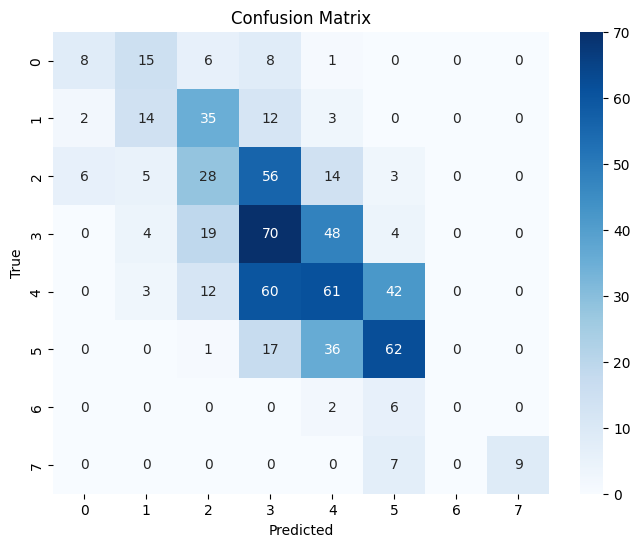

In [172]:
confusion_matrix_plot(y_testv2, y_predv2)

In [173]:
accuracy_rf_v2 = accuracy_score(y_testv2, y_predv2)
print("Accuracy:", accuracy_rf_v2)

Accuracy: 0.3711340206185567


The random forest model, excluding the feature importances below .030, performed worse than the previous one.